In [2]:
from sklearn.model_selection import cross_validate, GridSearchCV, KFold
from sklearn.metrics import make_scorer, r2_score
from src.utils import *
from src.InstrumentalVariable import InstrumentalVariable
import matplotlib.pyplot as plt

In [3]:
def grid_search(X, y):
    iv_model = InstrumentalVariable()
    grid_nu = np.linspace(0.0001, 0.2, num=20)
    grid_reg = np.logspace(-5, 5, num=20)
    grid_p_value = np.linspace(0, 98, num=20)
    params = {'l2_reg': grid_reg, 'critical_p_value': grid_p_value, 'nu': grid_nu}
    gs = GridSearchCV(iv_model, param_grid=params, scoring=make_scorer(r2_score), cv=10, verbose=1, n_jobs=-1)
    gs.fit(X, y)
    return gs.cv_results_

In [3]:
def evaluate_regression_model(model, X, y):
    scores = cross_validate(model, X, y, scoring=make_scorer(r2_score), cv=10, n_jobs=-1)
    return np.mean(scores['test_score'])

In [4]:
def evaluate_model_with_outliers(model, X, y, nu=0.1, n_splits=5, bootstrap=True, score=r2_score):
    kf = KFold(n_splits=n_splits)
    metric = 0
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        outliers = get_outlier_experiments(np.append(X_train[:,:,0], np.reshape(y_train, (-1, 1)), axis=1), nu=nu)
        mask = np.ones(len(X_train), np.bool)
        mask[outliers] = 0
        X_train, y_train = X_train[mask], y_train[mask]
        if bootstrap:
            bootstrap_inds = np.random.choice(len(X_train), len(X_train))
            X_train, y_train = X_train[bootstrap_inds], y_train[bootstrap_inds]
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        metric += score(y_test, y_pred)
    return metric / n_splits


In [5]:
def draw_long_short_plots(short_metrics, long_metrics, outliers=None, l0reg = None):
    for i, short in enumerate(short_metrics.swapaxes(0, 1)):
        inds = None
        if l0reg is not None:
            inds = extract_painted_inds(short, l0reg)
            short = short[inds]
        for j, long in enumerate(long_metrics.swapaxes(0, 1)):
            if inds is not None:
                long = long[inds]
            plt.plot(short[:, 0], long[:, 0], 'b.')
            if outliers is not None:
                outlined_short = short[outliers]
                outlined_long = long[outliers]
                plt.plot(outlined_short[:, 0], outlined_long[:, 0], 'r.')            
            if l0reg is None:
                plt.title('Long term metric dependency on short term metrics without l0 regularization')
            else:
                plt.title('Long term metric dependency on short term metrics with l0 regularization: ' + str(l0reg))
            plt.xlabel('short metric: ' + str(i))
            plt.ylabel('long metric: ' + str(j))
            plt.show()    

In [4]:
short_metrics_p, long_metrics_p = read_data(shift=True)
short_metrics = short_metrics_p[:, :, 0]
long_metrics = long_metrics_p[:, :, 0]

target_metric_p = long_metrics_p[:, 0, :]   # <--- here you can choose target (0, 1, 2, 3)
target_metric = target_metric_p[:, 0]

In [17]:
print(len(target_metric_p[target_metric_p[:, 1] > 95]))

23


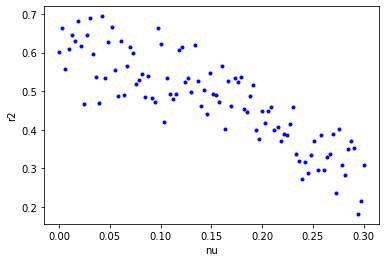

In [7]:
r2 = []
nu_l = np.linspace(0.0001, 0.3, num=100)
for nu in nu_l:
    iv_model = InstrumentalVariable(90)
    cur_r2 = evaluate_model_with_outliers(iv_model, short_metrics_p, target_metric, nu=nu, n_splits=10)
    if cur_r2 < 0:  #<-- it is for better visualisation, for target_metric_0 it should be changed on -1
        cur_r2 = 0
    r2.append(cur_r2)
plt.plot(nu_l, r2, 'b.')
plt.xlabel('nu')
plt.ylabel('r2')
# plt.savefig('MSE_nu_dependency.pdf')
plt.show()

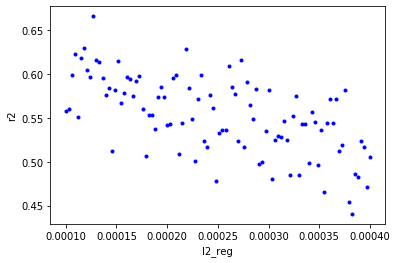

In [16]:
r2 = []
l2_reg_l = np.linspace(1e-4, 4e-4, num=100)
for l2_reg in l2_reg_l:
    iv_model = InstrumentalVariable(90, l2_reg)
    cur_r2 = evaluate_model_with_outliers(iv_model, short_metrics_p, target_metric, nu=0.1, n_splits=10)
    if cur_r2 < -1:
        cur_r2 = -1
    r2.append(cur_r2)
plt.plot(l2_reg_l, r2, 'b.')
plt.xlabel('l2_reg')
plt.ylabel('r2')
# plt.savefig('MSE_l2_dependency.pdf')
plt.show()

In [ ]:
outliers = get_outlier_experiments(np.append(short_metrics, long_metrics, axis=1))
draw_long_short_plots(short_metrics_p, long_metrics_p, outliers=outliers)

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

sm_train, sm_test, lm_train, lm_test = train_test_split(short_metrics, target_metric)
linreg = LinearRegression()
linreg.fit(sm_train, lm_train)
y_test = np.repeat(np.mean(lm_train), len(lm_test))
print(mean_squared_error(lm_test, y_test))


0.012866830500714677
